# install dependancies, takes around 45 seconds

Rendering Dependancies



In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1


Pacman Dependancies

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[all] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)


# Imports and Helper functions


In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import copy
from collections import namedtuple, deque

%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
import os
import torch 
import torch.nn as nn
import torch.nn.functional as tn
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import copy

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# **MOUNTAINCAR**

In [ ]:
env = wrap_env(gym.make("MountainCarContinuous-v0"))

In [ ]:
#check out the pacman action space!
print(env.action_space)
a=env.action_space.shape[0]
print(a)

Box(1,)
1


In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
  
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()

In [ ]:
print(type(observation))
observation = torch.from_numpy(observation)
print(observation)
print(observation.size()[0])

<class 'numpy.ndarray'>
tensor([-0.3499, -0.0095], dtype=torch.float64)
2


# **ACTOR MODEL**

In [ ]:
HID_LAYER1 = 128
HID_LAYER2 = 64

actiondim=env.action_space.shape[0]


class Actor(nn.Module):

  def __init__(self,env,name,chkpt_dir='tmp/ddpg'):
    super(Actor,self).__init__()
    observation = env.reset()
    observation = torch.from_numpy(observation)
    #saving the learnable parameters
    self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')

    #There are 3 layers input ,1 hidden,output

    #input is state observations 
    self.lin1 = nn.Linear(observation.size()[0],HID_LAYER1)
    self.batchnorm1 = nn.BatchNorm1d(HID_LAYER1)
    
    self.lin2 = nn.Linear(HID_LAYER1,HID_LAYER2)
    self.batchnorm2 = nn.BatchNorm1d(HID_LAYER2)
    
    #output is actions
    self.lin3 = nn.Linear(HID_LAYER2,actiondim)
    
    #Activation layers
    self.ReLU = nn.ReLU()
    #self.softmax = tn.softmax()
    self.Tanh = nn.Tanh()

  def forward(self,input1):
    #ip_norm = self.norm0(ip)
    h1 = self.ReLU(self.lin1(input1))
    #h1_norm = self.batchnorm1(h1)
    h2 = self.ReLU(self.lin2(h1))
    #h2_norm = self.batchnorm2(h2)
    action = self.Tanh((self.lin3(h2)))
    #actions = tn.softmax(actions)

    return action

  def save_checkpoint(self):
      print('... saving checkpoint ...')
      T.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
      print('... loading checkpoint ...')
      self.load_state_dict(T.load(self.checkpoint_file))




# **CRITIC MODEL**

In [ ]:
HID_LAYER1 = 128
HID_LAYER2 = 64

class critic(nn.Module):

  def __init__(self,env,name,chkpt_dir='tmp/ddpg'):
    super(critic,self).__init__()
    observation = env.reset()
    observation = torch.from_numpy(observation)
    actiondim=env.action_space.shape[0]
    #saving the learnable parameters
    self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')


    
    #There are 3 layers input ,1 hidden,output

    #input is state observations 
    self.lin1 = nn.Linear(observation.size()[0],HID_LAYER1)
    self.batchnorm1 = nn.BatchNorm1d(HID_LAYER1)
    
    self.lin2 = nn.Linear(HID_LAYER1+actiondim,HID_LAYER2)
    self.batchnorm2 = nn.BatchNorm1d(HID_LAYER2)
    
    #output is actions
    self.lin3 = nn.Linear(HID_LAYER2,1)
    
    #Activation layers
    self.ReLU = nn.ReLU()
    self.Tanh = nn.Tanh()

  def forward(self,action,input1):
    #ip_norm = self.norm0(ip)                            
    h1 = self.ReLU(self.lin1(input1))
    h1_norm = self.batchnorm1(h1)
    x = torch.cat((h1_norm,action),1)
    h2 = self.ReLU(self.lin2(x))
    qvalue = self.lin3(h2)
    return qvalue


  def save_checkpoint(self):
      print('... saving checkpoint ...')
      T.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
      print('... loading checkpoint ...')
      self.load_state_dict(T.load(self.checkpoint_file))






# **Replay Buffer**

In [ ]:
class rbuffer(object):
  def __init__(self,buffer_size):
    self.buffer_size = buffer_size
    self.position = 0
    self.memory = []
  
  def reset(self):
    self.position = 0
    self.memory = []
  
  def length(self):
    return len(self.memory)

  def push(self,batch):
    if len(self.memory) < self.buffer_size:
            self.memory.append(None)
    self.memory[self.position] = batch
    self.position = (self.position + 1) % self.buffer_size

  
  def sample_batch(self,batchSize):
    #if len(self.memory) == self.buffer_size:
    batch = random.sample(self.memory, batchSize)
    curState = [element[0] for element in batch]
    action = [element[1] for element in batch]
    nextState = [element[2] for element in batch]
    reward = [element[3] for element in batch]
    terminal = [element[4] for element in batch]
    # print('here')
    #   print(batch)
    return curState, action, nextState, reward, terminal




In [ ]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed=0, mu=0., theta=0.15, sigma=0.3):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


# **DDPG AGENT**

In [ ]:

# Hyperparameters for DDPG Algorithm
ACTOR_LR = 0.0001
CRITIC_LR = 0.001
MINIBATCH_SIZE = 64
NUM_EPISODES = 10000
MU = 0
SIGMA = 0.2
CHECKPOINT_DIR = './checkpoints/manipulator/'
BUFFER_SIZE = 1000000
DISCOUNT = 0.9
TAU = 0.001
WARMUP = 100
EPSILON = 0
EPSILON_DECAY = 1e-6
action_size = env.action_space.shape[0]
epsodereward=[]
Temp = 0

class DDPG_Agent(object):
  def __init__(self,env):
    self.env=env
    self.actor = Actor(self.env,name='Actor')
    self.critic = critic(self.env,name='Critic')
    self.targetactor = copy.deepcopy(Actor(self.env,name='targetActor'))
    self.targetcritic = copy.deepcopy(critic(self.env,name='targetCritic'))
    self.actor_Optim = optim.Adam(self.actor.parameters(), lr=ACTOR_LR)
    self.critic_Optim = optim.Adam(self.critic.parameters(), lr=CRITIC_LR)
    self.criticLoss = nn.MSELoss()
    self.replayBuffer = rbuffer(BUFFER_SIZE)
    self.batchSize = MINIBATCH_SIZE
    self.checkpoint_dir = CHECKPOINT_DIR
    self.discount = DISCOUNT
    self.Temp = Temp
    self.warmup = WARMUP
    self.epsilon = EPSILON
    self.noise = OUNoise(action_size)
    self.epsilon_decay = EPSILON_DECAY

  def maxaction(self,curstate,add_noise=True):
    state = torch.from_numpy(curstate).float()

    self.actor.eval()
    with torch.no_grad():
        action = self.actor(state).cpu().data.numpy()
    self.actor.train()
    
    if add_noise:
        action += self.epsilon * self.noise.sample()

    return action

  def qvaluelabel(self,nextstate,reward,done):
    nextaction = self.targetactor(nextstate)
    next_q=self.targetcritic(nextaction,nextstate)
    #If the episode ends then need to see if
    done = torch.ByteTensor(done)
    reward = torch.from_numpy(np.array(reward))
    target_q = reward + self.discount*(1-done)*next_q

    return target_q

  def replaybuffer1(self):
    count = 0
    observation = env.reset()
    if self.replayBuffer.length() >= self.warmup:
      pass
    else:
      while count<101:
        count+=1
        if np.random.sample() > self.epsilon:
          currstate = observation

          #your agent goes here
          action = self.maxaction(currstate)
          observation, reward, done, info = env.step(action)

          nextstate = observation
          reward = reward
          action = action
          terminal = done
          self.replayBuffer.push((currstate,action,nextstate,reward,terminal))
        else:
          currstate = observation

          #your agent goes here
          action = env.action_space.sample()
          observation, reward, done, info = env.step(action)

          nextstate = observation
          reward = reward
          action = action
          terminal = done
          self.replayBuffer.push((currstate,action,nextstate,reward,terminal))

  def updateTargets(self, target, original):
        """Weighted average update of the target network and original network
            Inputs: target actor(critic) and original actor(critic)"""
        
        for targetParam, orgParam in zip(target.parameters(), original.parameters()):
            targetParam.data.copy_((1 - TAU)*targetParam.data +  TAU*orgParam.data)

  def learn(self):
      self.Temp+=1
      if self.Temp % 20 == 0:
        self.replayBuffer.reset()

      if self.replayBuffer.length()>=100:
          pass
      else:
          self.replaybuffer1()
        
      currstate,action,nextstate,reward,terminal = self.replayBuffer.sample_batch(self.batchSize)
      currstate = torch.from_numpy(np.array(currstate))
      nextstate = torch.from_numpy(np.array(nextstate))
      action = torch.from_numpy(np.array(action))


      target_q = self.qvaluelabel(nextstate.float(), reward, terminal)
      #action = torch.from_numpy(action)
      qpredicted = self.critic(action.float(),currstate.float())

      #criticupdate
      self.critic_Optim.zero_grad()
      criticloss = self.criticLoss(target_q,qpredicted)
      criticloss.backward()
      self.critic_Optim.step()

      #actorupdate
      self.actor_Optim.zero_grad()
      action1 = self.actor(currstate.float())
      actorloss = -torch.mean(self.critic(action1,currstate.float() ))
      actorloss.backward()
      self.actor_Optim.step()

      #update target
      # self.update_network_parameters()

      self.updateTargets(self.targetcritic, self.critic)
      self.updateTargets(self.targetactor, self.actor)

In [ ]:
agent=DDPG_Agent(env)

In [ ]:
from google.colab import files


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 5, Average Score: -73.40, Max: -72.33, Min: -74.02, Time: 19.66
Episode 10, Average Score: -74.16, Max: -72.33, Min: -74.84, Time: 19.36
Episode 15, Average Score: -74.10, Max: -72.33, Min: -74.84, Time: 19.38
Episode 20, Average Score: -74.09, Max: -72.33, Min: -75.38, Time: 19.07
Episode 25, Average Score: -73.53, Max: -72.33, Min: -75.38, Time: 19.19
Episode 30, Average Score: -73.17, Max: -71.69, Min: -75.38, Time: 18.98
Episode 35, Average Score: -73.59, Max: -71.69, Min: -75.38, Time: 19.56
Episode 40, Average Score: -73.75, Max: -71.69, Min: -75.38, Time: 19.55
Episode 45, Average Score: -73.86, Max: -71.69, Min: -75.38, Time: 19.21
Episode 50, Average Score: -73.22, Max: -71.69, Min: -75.38, Time: 18.82
Episode 55, Average Score: -73.47, Max: -71.69, Min: -75.38, Time: 18.95
Episode 60, Average Score: -73.75, Max: -71.69, Min: -75.38, Time: 18.83
Episode 65, Average Score: -73.85, Max: -71.69, Min: -75.38, Time: 19.46
Episode 70, Average Score: -74.15, Max: -71.69, Min:

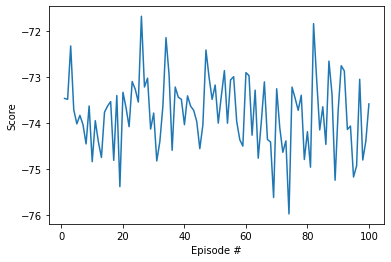

In [ ]:
import time
def ddpg(n_episodes=100, max_t=1500, print_every=5):
    scores_deque = deque(maxlen=print_every)
    scores = []
  
    for i_episode in range(1, n_episodes+1):
        
        state = env.reset()
        
        #agent.reset()
        score = 0
        timestep = time.time()
        for t in range(max_t):
            action = agent.maxaction(state)
            #env.render()
            action = np.clip(action, -1, 1)
            next_state, reward, done, _ = env.step(action)
            
            agent.learn()
            state = next_state
            score += reward
            if done:
                break 
                
        scores_deque.append(score)
        scores.append(score)
        score_average = np.mean(scores_deque)
        
        if i_episode % print_every == 0:
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                  .format(i_episode, score_average, np.max(scores), np.min(scores), time.time() - timestep), end="\n")
                    
        if np.mean(scores_deque)>90.0:            
            torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, score_average))            
            break            
            
            
    return scores

scores = ddpg()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()